In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## 1. 데이터 로딩 / データの準備

- https://oracleselixir.com/match-data/
- Obtain match data for 2019 from the above site and extract the results of the team's battle.
- The columns to be used are defined as follows.

### Column Definition
- kpm: Kills per minute
- dpm: Deaths per minute
- apm: Assists per minute
- dmgpm: Total damage dealt to champions per minute
- wpm: Wards placed per minute
- earnedgpm: Earned gold per minute
- cspm: Creep score per minute
- visiblewardclearrate: Percent of opposing team’s visible wards cleared
- invisiblewardclearrate: Percent of opposing team’s invisible wards cleared
- goldat10: Total gold earned at 10:00
- goldat15: Total gold earned at 15:00
- csat10: Creep score at 10:00
- csat15: Creep score at 15:00
- xpat10: Experience earned at 10:00
- firedrakes: Total infernal drakes killed by team
- waterdrakes: Total ocean drakes killed by team
- earthdrakes: Total mountain drakes killed by team
- airdrakes: Total cloud drakes killed by team
- elders: Total elder dragons killed by team
- teambaronkills: Total barons killed by team
- teamtowerkills: Total towers killed by team
- side: Map side (1: Blue, 0: Red)
- herald: Rift herald taken (1: yes, 0: no)
- fd: First dragon of game killed (1: yes, 0: no)
- fb: First blood kill (1: yes, 0: no)
- ft: First tower of game killed (1: yes, 0: no)
- firstmidouter: First team to kill mid lane outer tower (1: yes, 0: no)
- firsttothreetowers: First team to kill three towers (1: yes, 0: no)

In [2]:
df = pd.read_csv("team_stats.csv")
df.head()

,result,kpm,dpm,apm,dmgpm,wpm,earnedgpm,cspm,visiblewardclearrate,invisiblewardclearrate,...,elders,teambaronkills,teamtowerkills,side,herald,fd,fb,ft,firstmidouter,firsttothreetowers
0,0,0.389400,0.356950,0.843699,2026.111412,2.660898,1100.449973,32.806923,0.562500,0.315789,...,0.0,0.0,4.0,1,1.0,0.0,0.0,0.0,1.0,1.0
1,1,0.356950,0.389400,0.746349,2424.045430,2.888048,1203.154137,32.969173,0.531250,0.380000,...,0.0,1.0,8.0,0,0.0,1.0,1.0,1.0,0.0,0.0
2,1,0.419214,0.157205,1.126638,1667.711790,3.825328,1228.663755,32.358079,0.637931,0.366197,...,0.0,2.0,10.0,1,0.0,0.0,1.0,0.0,0.0,0.0
3,0,0.157205,0.419214,0.419214,1726.296943,3.379913,946.087336,31.755459,0.542169,0.365079,...,0.0,0.0,4.0,0,1.0,1.0,0.0,1.0,1.0,1.0
4,0,0.253165,0.379747,0.506329,1425.411392,3.322785,1075.943038,32.563291,0.739130,0.227273,...,0.0,0.0,3.0,1,1.0,0.0,0.0,0.0,1.0,0.0


## 2. 결측값 보정 / 欠損値の補完

- Check the missing values

In [3]:
df.isnull().any()

result                    False
kpm                       False
dpm                       False
apm                       False
dmgpm                     False
wpm                       False
earnedgpm                 False
cspm                      False
visiblewardclearrate       True
invisiblewardclearrate     True
goldat10                   True
goldat15                   True
csat10                     True
csat15                     True
xpat10                     True
firedrakes                 True
waterdrakes                True
earthdrakes                True
airdrakes                  True
elders                     True
teambaronkills             True
teamtowerkills             True
side                      False
herald                     True
fd                         True
fb                         True
ft                         True
firstmidouter              True
firsttothreetowers         True
dtype: bool

- Replace the missing values with average

In [4]:
cols = ["visiblewardclearrate", "invisiblewardclearrate", "goldat10", "goldat15", "csat10", "csat15", "xpat10"]
for col in cols:
    df[col].fillna(df[col].mean(), inplace=True)

- Replace the missing values with mode

In [5]:
# While doing, change the type.
cols = ["firedrakes", "waterdrakes", "earthdrakes", "airdrakes", "elders", "teambaronkills", "teamtowerkills"]
for col in cols:
    df[col] = df[col].fillna(df[col].mode().iloc[0]).astype("int64")

- Treat the missing values as zero

In [6]:
cols = ["herald", "fd", "fb", "ft", "firstmidouter", "firsttothreetowers"]
for col in cols:
    df[col] = df[col].fillna(0).astype("int64")

## 3. 탐색적 자료 분석 / 探索的データ解析

In [7]:
df.loc[:, "kpm":"teamtowerkills"].describe()

,kpm,dpm,apm,dmgpm,wpm,earnedgpm,cspm,visiblewardclearrate,invisiblewardclearrate,goldat10,...,csat10,csat15,xpat10,firedrakes,waterdrakes,earthdrakes,airdrakes,elders,teambaronkills,teamtowerkills
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,...,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,0.356480,0.357270,0.809529,1742.327265,3.635058,1139.399380,33.027031,0.563457,0.310709,15616.268680,...,320.891656,507.762142,18589.657223,0.519602,0.510579,0.509334,0.514001,0.094275,0.689795,5.990355
std,0.204875,0.204996,0.489455,458.401861,0.576267,185.645953,2.621198,0.109252,0.085146,832.240262,...,22.872441,35.247002,746.859504,0.751027,0.767602,0.739954,0.763074,0.320691,0.759159,3.876827
min,0.000000,0.000000,0.000000,484.611187,1.855288,665.866005,22.397476,0.133333,0.040000,13008.000000,...,204.000000,368.000000,14966.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200501,0.201334,0.419098,1414.865277,3.214286,979.874189,31.300305,0.488372,0.250000,15048.250000,...,307.000000,485.000000,18140.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.331362,0.332416,0.754305,1718.626068,3.583924,1153.034014,32.945299,0.566667,0.311111,15536.500000,...,322.000000,510.000000,18630.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.000000
75%,0.480453,0.480794,1.121226,2038.822333,4.001334,1292.257172,34.694738,0.638298,0.368421,16116.500000,...,336.000000,532.000000,19093.750000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,10.000000
max,1.818182,1.818182,3.005566,4517.736549,5.906164,1824.141002,43.440729,0.941176,0.604167,21281.000000,...,390.000000,611.000000,21258.000000,3.000000,3.000000,3.000000,3.000000,2.000000,4.000000,11.000000


### Average value by winning or defeat

In [8]:
df.groupby("result").mean()

,kpm,dpm,apm,dmgpm,wpm,earnedgpm,cspm,visiblewardclearrate,invisiblewardclearrate,goldat10,...,elders,teambaronkills,teamtowerkills,side,herald,fd,fb,ft,firstmidouter,firsttothreetowers
result,,,,,,,,,,,,,,,,,,,,,
0,0.222519,0.490969,0.481289,1549.726131,3.578970,983.164699,32.066271,0.504490,0.297719,15357.799794,...,0.050404,0.199129,2.521469,0.452396,0.396391,0.356565,0.412570,0.315495,0.252022,0.206596
1,0.490440,0.223571,1.137770,1934.928398,3.691146,1295.634062,33.987791,0.622424,0.323699,15874.737566,...,0.138146,1.180460,9.459241,0.547604,0.599876,0.642813,0.586808,0.683883,0.746733,0.792159


### Correlation

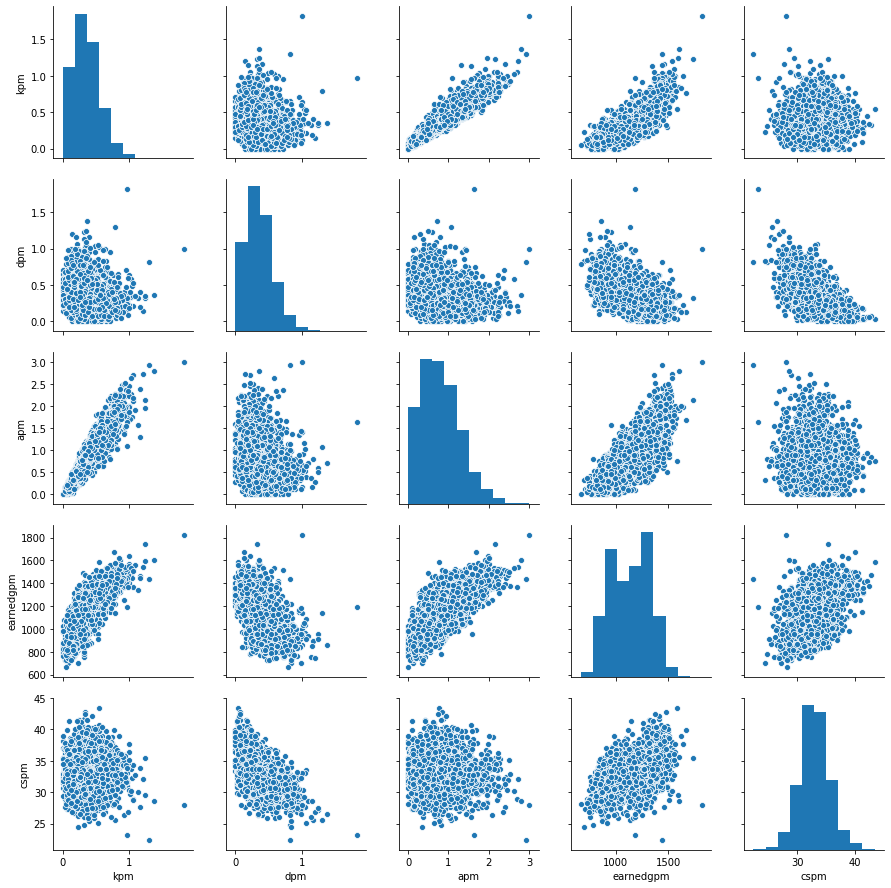

In [9]:
sns.pairplot(df[["kpm", "dpm", "apm", "earnedgpm", "cspm"]])

### Visualize the number of towers that have been destroyed

- The rates of winning were quite high if the team destroyed more than seven towers.
- However, it is natural to interpret that it was able to destroy more than seven towers because the team won.

[Text(0, 0.5, 'Win Rate')]

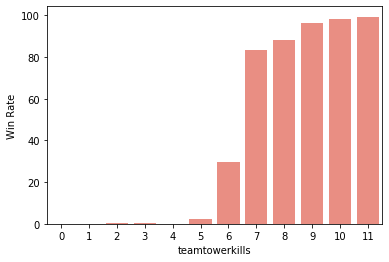

In [10]:
ax = sns.barplot(x="teamtowerkills", y="result", data=df, estimator=lambda x: sum(x) / len(x) * 100, ci=None, color="salmon")
ax.set(ylabel="Win Rate")

### Visualize the number of times Baron Nashor has been disposed

- In case of more than 4 times, the game is long-term and the winning rate is judged to be 50%.
- In other words, victory or defeat is determined as a result of the team fight regardless of the baron buff.

[Text(0, 0.5, 'Win Rate')]

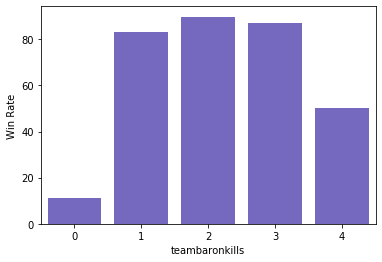

In [11]:
ax = sns.barplot(x="teambaronkills", y="result", data=df, estimator=lambda x: sum(x) / len(x) * 100, ci=None, color="slateblue")
ax.set(ylabel="Win Rate")

## 4. scikit-learn을 이용한 기계 학습 / scikit-learnを使った機械学習

- Split into feature variables and target variables

In [12]:
X = df.drop("result", axis=1)
y = df["result"]

- Divide the data into train sets and test sets

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Grid Search

- Set up several models and hyper parameters

In [14]:
model_param_set = {
    LogisticRegression(): {
        "logisticregression__C": [10 ** i for i in range(-3, 3)],
        "logisticregression__solver": ["liblinear", "lbfgs"],
        "logisticregression__max_iter": [100, 200, 300],
        "logisticregression__random_state": [0],
    },
    SVC(): {
        "svc__kernel": ["linear", "rbf"],
        "svc__C": [10 ** i for i in range(-3, 3)],
        "svc__gamma": [0.001, 0.0001],
        "svc__random_state": [0]
    },
    RandomForestClassifier(): {
        "randomforestclassifier__max_depth": [i for i in range(1, 4)],
        "randomforestclassifier__n_estimators": [50 * i for i in range(1, 5)],
        "randomforestclassifier__random_state": [0]
    }
}

- The logistic regression looks best.

In [15]:
for model, param in model_param_set.items():
    pipe = make_pipeline(StandardScaler(), model)
    grid = GridSearchCV(pipe, param_grid=param, cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    print("Test Score: {:.3f}".format(grid.score(X_test, y_test)))
    print("-------------------------------------------------")

{'logisticregression__C': 1, 'logisticregression__max_iter': 100, 'logisticregression__random_state': 0, 'logisticregression__solver': 'lbfgs'}
Test Score: 0.980
-------------------------------------------------
{'svc__C': 0.1, 'svc__gamma': 0.001, 'svc__kernel': 'linear', 'svc__random_state': 0}
Test Score: 0.978
-------------------------------------------------
{'randomforestclassifier__max_depth': 3, 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__random_state': 0}
Test Score: 0.969
-------------------------------------------------


## 5. 로지스틱 회귀의 결과 확인 / ロジスティック回帰の結果確認

In [16]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(C=1, solver="lbfgs", max_iter=100, random_state=0))
pipe_lr.fit(X_train, y_train)
pipe_lr.steps

[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('logisticregression',
  LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False))]

### Result of class classification

In [17]:
y_pred = pipe_lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       408
           1       0.98      0.98      0.98       396

    accuracy                           0.98       804
   macro avg       0.98      0.98      0.98       804
weighted avg       0.98      0.98      0.98       804



### Coefficients of the model

In [18]:
coef_lr = pipe_lr.steps[1][1].coef_[0]
coef_lr

array([ 6.95058401e-01, -2.43039568e+00,  1.67093267e+00, -1.15224798e-01,
       -1.77610237e-01,  2.27016939e+00,  4.02459047e-01,  3.54380757e-01,
        7.29590813e-02,  2.22664419e-02, -6.17228595e-01, -6.34880760e-02,
       -5.18251279e-01,  1.87491618e-01, -2.21002845e-01,  3.72923192e-02,
        4.62025080e-02, -4.63021248e-02,  4.62747881e-02, -3.18516815e-01,
        3.57306315e+00, -3.99451458e-02,  1.37052809e-01,  1.70218956e-01,
       -4.19790214e-01,  2.61755046e-01, -3.25858318e-04,  6.58258493e-02])

- As it may sound obvious, the destruction of towers and the acquisition of gold are important to win.
- A rise in dpm(deaths per minute) reduces the chance of winning.

In [19]:
for col in np.argsort(coef_lr)[::-1]:
    print("{}: {}".format(df.columns[1:][col], coef_lr[col]))

teamtowerkills: 3.5730631491446463
earnedgpm: 2.2701693929732985
apm: 1.6709326688767296
kpm: 0.6950584010419265
cspm: 0.40245904693755424
visiblewardclearrate: 0.3543807566517138
ft: 0.26175504572577596
xpat10: 0.18749161776074205
fd: 0.17021895621760258
herald: 0.13705280850643942
invisiblewardclearrate: 0.07295908127039198
firsttothreetowers: 0.06582584930059465
elders: 0.04627478809904468
earthdrakes: 0.04620250804224963
waterdrakes: 0.03729231923779126
goldat10: 0.022266441923326757
firstmidouter: -0.00032585831755843424
side: -0.03994514576452356
airdrakes: -0.04630212478703613
csat10: -0.06348807596206633
dmgpm: -0.11522479810517584
wpm: -0.1776102365441871
firedrakes: -0.22100284505296258
teambaronkills: -0.31851681518079406
fb: -0.419790214211771
csat15: -0.5182512786640995
goldat15: -0.6172285950308468
dpm: -2.4303956799418036
